## I. Import Libraries and Data

In [1]:
#math and modelling
import re
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from tpot import TPOTClassifier
from sklearn.feature_extraction.text import CountVectorizer
from scipy.sparse import coo_matrix, hstack, csr_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import Counter

#readability
import textstat

#sytax
import nltk

#plotting
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.colors import ListedColormap
from matplotlib.colors import LogNorm
plt.style.use('bmh')
from wordcloud import WordCloud, STOPWORDS

## II. Define Functions

### A. Cleaning and Read Functions

In [2]:
def cleanArticle(string):
    strip_special_chars = re.compile("[^A-Za-z0-9' ]+")
    string = string.lower().replace("<br />", " ")
    return re.sub(strip_special_chars, "", string.lower())

def read_perez_dataset(dataset_name):
    
    def remove_numbers(in_str):
        return re.sub(r'[0-9]+', '', in_str)
    
    print("Reading dataset")
    result_data_list = []
    data_dir = PEREZ_DATASET_PATH
    for news_type in ['fake', 'legit']:
        folder = '%s/%s/%s' % (data_dir, dataset_name, news_type)
        for fname in os.listdir(folder):
            result_data = {}
            result_data['dataset_name'] = dataset_name
            result_data['news_type'] = news_type
            if news_type == 'fake':
                result_data['is_fake'] = 1
            else:
                result_data['is_fake'] = 0
            if dataset_name == 'fakeNewsDataset':
                result_data['news_category'] = remove_numbers(fname.split('.')[0])
            result_data['file_name'] = fname
            filepath = os.path.join(folder, fname)
            with open(filepath, 'r', encoding="utf8") as f:
                file_data = f.read().split('\n')
                # Some articles don't have a headline, but only article body.
                if len(file_data) > 1:
                    news_content_data = ' '.join(file_data[2:])
                    result_data['news_headline'] = file_data[0]
                else:
                    news_content_data = file_data[0]
                    result_data['news_headline'] = ''
                result_data['news_content'] = news_content_data
                result_data['news_all'] = ' '.join(file_data[0:])
                result_data_list.append(result_data)
                
    df = pd.DataFrame(result_data_list)
    
    df['news_all_clean'] = df['news_all'].apply(lambda a: cleanArticle(a))
    
    X_train, X_test, y_train, y_test = train_test_split(df.drop(['is_fake',
                                                               'news_type','file_name'],
                                                               axis = 1), 
                                                        df['is_fake'], 
                                                        test_size=.2, random_state=RANDOM_SEED)
    
    print("Finished reading dataset")
    return df, X_train.reset_index(drop = True), y_train.reset_index(drop = True), X_test.reset_index(drop = True), y_test.reset_index(drop = True)

def model_report(title, y_test, predictions, predictions_proba):

    """
    Output: Classification report, confusion matrix, and ROC curve
    """
    print(title)
    print("---------")
    print(classification_report(y_test, predictions))

    cm = metrics.confusion_matrix(y_test, predictions)
    plt.figure(figsize=(3,3))
    sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
    plt.ylabel('Actual label');
    plt.xlabel('Predicted label');
    all_sample_title = 'Accuracy: {0}'.format(round(metrics.accuracy_score(y_test, predictions),2))
    plt.title(all_sample_title, size = 15)
    plt.show()
    
    fpr, tpr, threshold = metrics.roc_curve(y_test, predictions_proba)
    roc_auc = metrics.auc(fpr, tpr)

    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()
    
def example_printer(df, labels, fake = True, pos = 0, show_predict = False, pred_labels = [], pred_fake = True):
    """
    Output examples of fake or not fake news.
    """
    print("_________________________________________________________________________________________________")
    if fake: 
        val = 1
        print("True Label: Fake News")
    else:
        val = 0
        print("True Label: Not Fake News")
    if show_predict:
        if pred_fake: 
            pred_val = 1
            print("Predicted Label: Fake News")
        else:
            pred_val = 0
            print("Predicted Label: Not Fake News")
        if pred_fake == fake:
            print("Correct Prediction!")
        else:
            print("Incorrect Prediction.")
        print("")
        print("Headline:\n", df['news_headline'][(labels==val) & (pred_labels==pred_val)].iloc[pos]) 
        print("Article:\n", df['news_content'][(labels==val) & (pred_labels==pred_val)].iloc[pos]) 
        print("_________________________________________________________________________________________________")
    else:
        print("")
        print("Headline:\n", df['news_headline'][labels==val].iloc[pos]) 
        print("Article:\n", df['news_content'][labels==val].iloc[pos]) 
        print("_________________________________________________________________________________________________")
    
def wordcloud_maker(df):
    """
    Input: Complete data set with column 'news_all_clean' and 'is_fake'
    Output: Two word clouds for fake and not fake
    """
    fake = df[df['is_fake']==1]
    not_fake = df[df['is_fake']==0]

    mpl.rcParams['font.size']=12        
    mpl.rcParams['savefig.dpi']=100         
    mpl.rcParams['figure.subplot.bottom']=.1 

    stopwords = set(STOPWORDS)

    wordcloud = WordCloud(
                              background_color='white',
                              stopwords=stopwords,
                              max_words=50,
                              max_font_size=50, 
                              random_state=42
                             ).generate(str(fake['news_all_clean']))

    fig = plt.figure(1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title("Word Cloud for Fake News",fontsize=22, fontweight='bold')
    plt.show()

    wordcloud = WordCloud(
                              background_color='white',
                              stopwords=stopwords,
                              max_words=50,
                              max_font_size=50, 
                              random_state=42
                             ).generate(str(not_fake['news_all_clean']))

    fig = plt.figure(1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.tight_layout(pad=0)
    plt.title("Word Cloud for Not Fake News",fontsize=22, fontweight='bold')
    plt.show()
    

### B. Linguistic-based feature creators

#### 1. Ngram & Punctuation

In [3]:
def pad_punct(s):
    """
    Add padding around specified punctuation.
    """
    s = re.sub('([.,!?():])', r' \1 ', s)
    s = re.sub('\s{2,}', ' ', s)
    return s
def tfidf_vectorizer_custom(train, test, ngram_range):
    """
    Create a tfidf vectorized set for train and test data that counts punctuation.
    Ngram range = (1,3)
    """
    train = train.apply(pad_punct)
    test = test.apply(pad_punct)
    vect = TfidfVectorizer(token_pattern=r"(?u)\b\w\w+\b|!|\.|,|\)|\(|\:|\?|\"|\'", #pattern keep punctuation in vectorizer
                          ngram_range = ngram_range).fit(train)
    vocab = vect.vocabulary_.keys()
    vocab = sorted(vocab, key=len)
    print("Traing data info:")
    print('- Vocabulary len:', len(vect.get_feature_names()))
    print('- Longest phrase:', max(vect.vocabulary_, key=len))
    print('- Smallest 10 phrases:', vocab[0:10])
    print('- Sample of features:',np.array(vect.get_feature_names()))
    train_vectorized = vect.transform(train)
    test_vectorized = vect.transform(test)
    return train_vectorized, test_vectorized, vect.get_feature_names()

#### 2. Psycholinguistic features

In [4]:
def LIWC_counter(df1, df_LIWC, train_LIWC):
    """
    Inputs: - Data set with field: news_all_clean
            - Preprocessed LIWC lookup table
    Ouput:  - Data set with 73 additional fields for LIWC count results (normalized over string word count)
    """
    df = df1.copy()
    LIWC_vars = train_LIWC.drop('Word', axis = 1).columns.values
    for i in LIWC_vars:
        df[i] = 0
        words = df_LIWC[df_LIWC[i] == 1]['Word']
        for a in words:
            df[i] = (df[i] + 
                df.news_all_clean.str.count(str(" " + a + " "))  + #free floating word
                df.news_all_clean.str.count(str("^" + a + " ")) +  #start word
                df.news_all_clean.str.count(str(" " + a + "$")))   #end word
        df[i] = df[i] / df.news_all_clean.str.count(" ") #normalize over word count
    return df, LIWC_vars

#### 3. Readability

In [5]:
def readability_enricher(df1):
    """
    Input: a dataframe with column "news_all" to be analyzed for a variety of readbility metrics.
    Output: the inputted dataframe, enriched with all readbility metrics (there are a total of 10, one of which is categorical).
    """
    df = df1.copy()
    df_drop = df1.copy()
    df["flesch_reading_ease"]=0.0
    df["smog_index"]=0.0
    df["flesch_kincaid_grade"]=0.0
    df["coleman_liau_index"]=0.0
    df["automated_readability_index"]=0.0
    df["dale_chall_readability_score"]=0.0
    df["difficult_words"]=0.0
    df["linsear_write_formula"]=0.0
    df["gunning_fog"]=0.0
    df["text_standard"]=0.0

    for i in range(df.shape[0]):
        text = df['news_all'].iloc[i]
        df.loc[i,("flesch_reading_ease")]= textstat.flesch_reading_ease(text)
        df.loc[i,("smog_index")]= textstat.smog_index(text)
        df.loc[i,("flesch_kincaid_grade")]= textstat.flesch_kincaid_grade(text)
        df.loc[i,("coleman_liau_index")]= textstat.coleman_liau_index(text)
        df.loc[i,("automated_readability_index")]= textstat.automated_readability_index(text)
        df.loc[i,("dale_chall_readability_score")]= textstat.dale_chall_readability_score(text)
        df.loc[i,("difficult_words")]= textstat.difficult_words(text)
        df.loc[i,("linsear_write_formula")]= textstat.linsear_write_formula(text)
        df.loc[i,("gunning_fog")]= textstat.gunning_fog(text)
        df.loc[i,("text_standard")]= textstat.text_standard(text)
    
    return df, df.drop(df_drop.columns.values, axis = 1).drop(["text_standard"],axis = 1).columns.values

#### 4. Syntax

In [6]:
def POS_tagger(text):
    """
    Tag POS using nltk. Return a single "sentence" with the POS of each word treated like a "word."
    """
    tokens = nltk.word_tokenize(text)
    text = nltk.Text(tokens)
    tags = nltk.pos_tag(text)
    return " ".join([i[1] for i in tags])

def POS_enricher(df1):
    """
    Input: a dataframe with column "news_headline" and "news_content".
    Output: the inputted dataframe, with the columns "news_headline_POS" and "news_content_POS" created which are a single sentence with the 
    POS of each word represented as word in that same position.
    """
    df = df1.copy()
    df["news_headline_POS"]=""
    df["news_content_POS"]=""
    
    for i in range(df.shape[0]):
        text_headline = cleanArticle(POS_tagger(df['news_headline'].apply(lambda a: cleanArticle(a)).iloc[i]))
        text_content = cleanArticle(POS_tagger(df['news_content'].apply(lambda a: cleanArticle(a)).iloc[i]))
        
        df.loc[i,("news_headline_POS")]= text_headline
        df.loc[i,("news_content_POS")]= text_content
    
    return df

## III. Read in Data, Define Test/Train Set

In [7]:
RANDOM_SEED = 42
PEREZ_DATASET_PATH = "../data/fakeNewsDatasets_Perez-Rosas2018"
np.random.seed(RANDOM_SEED)

### A. fakeNewsDataset

In [8]:
news_perez_full, news_train_data, news_train_labels, news_test_data, news_test_labels = read_perez_dataset('fakeNewsDataset')
news_train_data.head()

Reading dataset
Finished reading dataset


,dataset_name,news_all,news_category,news_content,news_headline,news_all_clean
0,fakeNewsDataset,Real Madrid is willing to pay £100m for Eden H...,sports,"says Ramon Calderon ""Real Madrid are not in a ...",Real Madrid is willing to pay £100m for Eden H...,real madrid is willing to pay 100m for eden ha...
1,fakeNewsDataset,Women arrested three times is Melania Trump ...,polit,(CNN) A lady resembling Presidents Trump's wif...,Women arrested three times is Melania Trump,women arrested three times is melania trump ...
2,fakeNewsDataset,Alec Baldwin says he nearly passed on playing...,entmt,Alec Baldwin has revealed that he almost passe...,Alec Baldwin says he nearly passed on playing...,alec baldwin says he nearly passed on playing...
3,fakeNewsDataset,Will Smith reunites with Fresh Prince Pals to ...,entmt,Will Smith is back together with the cast of T...,Will Smith reunites with Fresh Prince Pals to ...,will smith reunites with fresh prince pals to ...
4,fakeNewsDataset,"Instagram adds two-factor authentication, secu...",tech,Instagram just made your account harder to hac...,"Instagram adds two-factor authentication, secu...",instagram adds twofactor authentication securi...


### B. celebrityDataset

In [9]:
celeb_perez_full, celeb_train_data, celeb_train_labels, celeb_test_data, celeb_test_labels = read_perez_dataset('celebrityDataset')
celeb_train_data.head()

Reading dataset
Finished reading dataset


,dataset_name,news_all,news_content,news_headline,news_all_clean
0,celebrityDataset,Malia Obama Has Barack And Michelle Worried – ...,"Malia Obama, 18, is adjusting to her new life ...",Malia Obama Has Barack And Michelle Worried – ...,malia obama has barack and michelle worried c...
1,celebrityDataset,Scarlett Johansson's New Man Has Confirmed The...,From the editors of HelloGiggles There’s been...,Scarlett Johansson's New Man Has Confirmed The...,scarlett johansson's new man has confirmed the...
2,celebrityDataset,Tyga To Reveal The Ugly Truth About Kylie Jenn...,Tyga and Kylie Jenner have made it to Splitsvi...,Tyga To Reveal The Ugly Truth About Kylie Jenn...,tyga to reveal the ugly truth about kylie jenn...
3,celebrityDataset,How Janet Jackson lost 70 pounds The 51-year-...,The 51-year-old new mom is sporting a sleek ph...,How Janet Jackson lost 70 pounds,how janet jackson lost 70 pounds the 51yearol...
4,celebrityDataset,Halle Berry Jokes About Pregnancy Rumors UPDA...,UPDATE: Halle Berry joked about the pregnancy ...,Halle Berry Jokes About Pregnancy Rumors,halle berry jokes about pregnancy rumors upda...


## IV. Run Train/Test Set through LIWC Rented License

We rented the LIWC dataset (for 30 days), as seen here: https://store5.esellerate.net/store/checkout/CustomLayout.aspx?s=STR6622550055&pc=&page=OnePageMoreInfo.htm&SkuRefNum=SKU48070077205

We downloaded the software, outputted the train/test set, ran the train/test set through the LIWC software, and uploaded the LIWC results.
The software marks words to 73 LIWC categories in a binary format (with an 'X')

In [10]:
#1. FakeNews Dataset
news_train_data['news_all'].to_csv("train_data_news_all_forLIWC.txt")
news_test_data['news_all'].to_csv("test_data_news_all_forLIWC.txt")
news_train_LIWC = pd.read_csv(
    "LIWC2015 Results (train_data_news_all_clean_forLIWC).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)
news_test_LIWC = pd.read_csv(
    "LIWC2015 Results (test_data_news_all_clean_forLIWC).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)

#2. Celebrity Dataset
celeb_train_data['news_all'].to_csv("train_data_news_all_forLIWC_celeb.txt")
celeb_test_data['news_all'].to_csv("test_data_news_all_forLIWC_celeb.txt")
celeb_train_LIWC = pd.read_csv(
    "LIWC2015 Results (train_data_news_all_forLIWC_celeb).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)
celeb_test_LIWC = pd.read_csv(
    "LIWC2015 Results (test_data_news_all_forLIWC_celeb).csv").fillna(0).drop('Unnamed: 74', axis = 1).replace('X',1)

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2698: DtypeWarning: Columns (7,8,10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [11]:
print("LIWC Fields:\n",news_test_LIWC.columns.values)
news_train_LIWC.head()

LIWC Fields:
 ['Word' 'function' 'pronoun' 'ppron' 'i' 'we' 'you' 'shehe' 'they' 'ipron'
 'article' 'prep' 'auxverb' 'adverb' 'conj' 'negate' 'verb' 'adj'
 'compare' 'interrog' 'number' 'quant' 'affect' 'posemo' 'negemo' 'anx'
 'anger' 'sad' 'social' 'family' 'friend' 'female' 'male' 'cogproc'
 'insight' 'cause' 'discrep' 'tentat' 'certain' 'differ' 'percept' 'see'
 'hear' 'feel' 'bio' 'body' 'health' 'sexual' 'ingest' 'drives'
 'affiliation' 'achieve' 'power' 'reward' 'risk' 'focuspast'
 'focuspresent' 'focusfuture' 'relativ' 'motion' 'space' 'time' 'work'
 'leisure' 'home' 'money' 'relig' 'death' 'informal' 'swear' 'netspeak'
 'assent' 'nonflu' 'filler']


,Word,function,pronoun,ppron,i,we,you,shehe,they,ipron,...,home,money,relig,death,informal,swear,netspeak,assent,nonflu,filler
0,he,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,he'd,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,he's,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,her,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,herself,1,1,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


## IV. Brief EDA

### A. fakeNewsDataset

In [12]:
print("Full FakeNews size: ", news_perez_full.shape)
print("FakeNews training size: ",news_train_labels.shape)
for i in [True, False]:
    example_printer(news_train_data, news_train_labels, fake = i, pos = 0)

Full FakeNews size:  (480, 9)
FakeNews training size:  (384,)
_________________________________________________________________________________________________
True Label: Fake News

Headline:
 Real Madrid is willing to pay £100m for Eden Hazard
Article:
 says Ramon Calderon "Real Madrid are not in a "very good situation" financially but would be willing to pay £100m to sign Chelsea's Eden Hazard says new president Ramon Calderon. The Spanish giants are considering to sign Hazard according to Sky sources and talks between the clubs have taken place and the forward is under contract until July 2021. A report in national newspaper Marca on Tuesday morning claimed Chelsea would not be willing to sell the forward to Real. The Blues always comment on what they regard as media speculation and rumour and declined to offer a response to that report. However Calderon has not claimed that a potential move would depend on the wishes of the Belgian and says that would not be key if the Champions L

In [13]:
print("Equal distribution among fake news and among news category:")
print(news_perez_full.groupby(['news_category','is_fake']).size())

Equal distribution among fake news and among news category:
news_category  is_fake
biz            0          40
               1          40
edu            0          40
               1          40
entmt          0          40
               1          40
polit          0          40
               1          40
sports         0          40
               1          40
tech           0          40
               1          40
dtype: int64


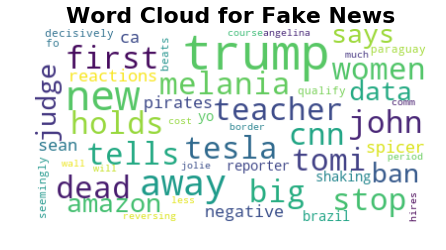

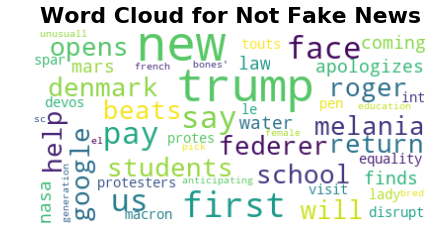

In [14]:
wordcloud_maker(news_perez_full)

### B. celebrityDataset

In [15]:
print("Full Celebrity size: ", celeb_perez_full.shape)
print("Celebrity training size: ", celeb_train_labels.shape)
for i in [True, False]:
    example_printer(news_train_data, news_train_labels, fake = i, pos = 0)
for i in [True, False]:
    example_printer(celeb_train_data, celeb_train_labels, fake = i, pos = 0)

Full Celebrity size:  (500, 8)
Celebrity training size:  (400,)
_________________________________________________________________________________________________
True Label: Fake News

Headline:
 Real Madrid is willing to pay £100m for Eden Hazard
Article:
 says Ramon Calderon "Real Madrid are not in a "very good situation" financially but would be willing to pay £100m to sign Chelsea's Eden Hazard says new president Ramon Calderon. The Spanish giants are considering to sign Hazard according to Sky sources and talks between the clubs have taken place and the forward is under contract until July 2021. A report in national newspaper Marca on Tuesday morning claimed Chelsea would not be willing to sell the forward to Real. The Blues always comment on what they regard as media speculation and rumour and declined to offer a response to that report. However Calderon has not claimed that a potential move would depend on the wishes of the Belgian and says that would not be key if the Champions

In [16]:
print("Equal distribution among fake news:")
print(celeb_perez_full.groupby(['is_fake']).size())

Equal distribution among fake news:
is_fake
0    250
1    250
dtype: int64


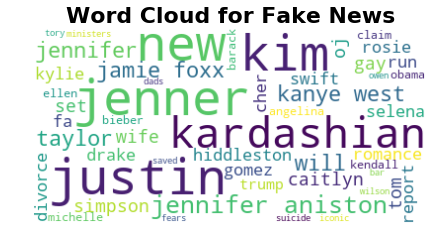

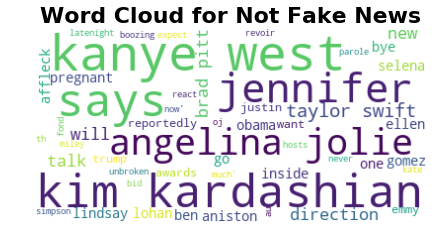

In [17]:
wordcloud_maker(celeb_perez_full)

## V. Create Feature-Enriched Training/Testing Datasets

### A. Implement Feature Creating Functions

#### 1. Ngram & Punctuation

In [18]:
#1. FakeNews
news_train_data_vectorized, news_test_data_vectorized, news_ngram_punct_names = tfidf_vectorizer_custom(
    news_train_data['news_all'], news_test_data['news_all'], ngram_range = (1,2))
print("train shape:", news_train_data_vectorized.shape)

Traing data info:
- Vocabulary len: 39803
- Longest phrase: becomeincreasingly difficult
- Smallest 10 phrases: ['"', "'", '.', ':', '(', ')', ',', '?', '!', 'is']
- Sample of features: ['!' '! !' '! "' ... 'zombie apocalypse' 'zuckerberg' 'zuckerberg ,']
train shape: (384, 39803)


In [19]:
#2. Celeb
celeb_train_data_vectorized, celeb_test_data_vectorized, celeb_ngram_punct_names = tfidf_vectorizer_custom(
    celeb_train_data['news_all'], celeb_test_data['news_all'], ngram_range = (1,2))
print("train shape:", celeb_train_data_vectorized.shape)

Traing data info:
- Vocabulary len: 98647
- Longest phrase: 3333333333333333333333333333333333333 triplets
- Smallest 10 phrases: ['?', ',', '.', ':', "'", '(', ')', '!', '"', 'in']
- Sample of features: ['!' '! !' '! "' ... 'zwang ,' 'über' 'über talented']
train shape: (400, 98647)


#### 2. Psycholinguistic features

In [20]:
#1. FakeNews
news_train_data_LIWC, news_train_LIWC_vars = LIWC_counter(news_train_data, news_train_LIWC, news_train_LIWC)
news_test_data_LIWC, news_test_LIWC_vars = LIWC_counter(news_test_data, news_test_LIWC, news_train_LIWC)
#2. Celeb
celeb_train_data_LIWC, celeb_train_LIWC_vars = LIWC_counter(celeb_train_data, celeb_train_LIWC, celeb_train_LIWC)
celeb_test_data_LIWC, celeb_test_LIWC_vars = LIWC_counter(celeb_test_data, celeb_test_LIWC, celeb_train_LIWC)

#### 3. Readability

In [21]:
#1. FakeNews
news_train_data_readability, news_train_readability_vars = readability_enricher(news_train_data)
news_test_data_readability, news_test_readability_vars = readability_enricher(news_test_data)
#2. Celb
celeb_train_data_readability, celeb_train_readability_vars = readability_enricher(celeb_train_data)
celeb_test_data_readability, celeb_test_readability_vars = readability_enricher(celeb_test_data)

#### 4. Syntax

In [22]:
def syntax_patter_counter(train_data, test_data):
    """
    Input: Training and Testing set
    Ouptu: Enriched sets with tfidf of POS tags for text in news_content and news_headline.
    """
    train_POS_init = POS_enricher(train_data)
    test_POS_init = POS_enricher(test_data)

    POS_headline_train_data_vectorized, POS_headline_test_data_vectorized, _ = tfidf_vectorizer_custom(
        train_POS_init['news_headline_POS'], test_POS_init['news_headline_POS'], ngram_range = (1,3))

    POS_content_train_data_vectorized, POS_content_test_data_vectorized, _ = tfidf_vectorizer_custom(
        train_POS_init['news_content_POS'], test_POS_init['news_content_POS'], ngram_range = (1,3))

    train_POS = hstack([POS_headline_train_data_vectorized, POS_content_train_data_vectorized])
    test_POS = hstack([POS_headline_test_data_vectorized, POS_content_test_data_vectorized])
    
    return train_POS, test_POS

#1. FakeNews
news_train_POS, news_test_POS = syntax_patter_counter(news_train_data, news_test_data)

#2. Celeb
celeb_train_POS, celeb_test_POS = syntax_patter_counter(celeb_train_data, celeb_test_data)

Traing data info:
- Vocabulary len: 1178
- Longest phrase: vbz nns rbr
- Smallest 10 phrases: ["'", 'jj', 'nn', 'to', 'vb', 'cd', 'in', 'rb', 'md', 'cc']
- Sample of features: ["'" "' '" "' ' in" ... 'wrb vbg vbp' 'wrb vbz' 'wrb vbz nn']
Traing data info:
- Vocabulary len: 4500
- Longest phrase: nns vbp vbg
- Smallest 10 phrases: ["'", 'nn', 'jj', 'rb', 'in', 'dt', 'cc', 'md', 'vb', 'to']
- Sample of features: ["'" "' '" "' ' cc" ... 'wrb vbz' 'wrb vbz cd' 'wrb vbz jj']
Traing data info:
- Vocabulary len: 1581
- Longest phrase: vbz vbn prp
- Smallest 10 phrases: ["'", 'nn', 'cc', 'md', 'vb', 'rb', 'in', 'jj', 'to', 'dt']
- Sample of features: ["'" "' '" "' ' cc" ... 'wrb prp vbz' 'wrb to' 'wrb to vb']
Traing data info:
- Vocabulary len: 7852
- Longest phrase: vbz prp nns
- Smallest 10 phrases: ["'", 'cd', 'to', 'jj', 'nn', 'in', 'dt', 'cc', 'rb', 'vb']
- Sample of features: ["'" "' '" "' ' cc" ... 'wrb vbz vbn' 'wrb wrb' 'wrb wrb prp']


### B. Unify All Features in Single Dataset

In [23]:
def add_feature(sparse, df_to_sparse, df_ignore):
    """
    Returns sparse feature matrix with added feature.
    """
    return hstack([coo_matrix(df_to_sparse.drop(df_ignore.columns.values, axis = 1)),sparse])

def add_categorical_feature(train_sparse, test_sparse, train_data, test_data, categorical_column, collapse = True):
    """
    Returns sparse feature matrix with added feature by creating a countvectorizer of feature.
    """
    vectcat = CountVectorizer()
    vectcat.fit(train_data[categorical_column])
    train_category_vec = vectcat.transform(train_data[categorical_column])
    test_category_vec  = vectcat.transform(test_data[categorical_column])
    train_final = hstack([train_sparse, train_category_vec])
    test_final =  hstack([test_sparse, test_category_vec])
    return train_final, test_final, vectcat.get_feature_names()

#### 1. FakeNews

In [24]:
#1. Combine ngram and LIWC
news_train_ngram_LIWC = add_feature(news_train_data_vectorized, news_train_data_LIWC, news_train_data)
news_test_ngram_LIWC = add_feature(news_test_data_vectorized, news_test_data_LIWC, news_test_data)

#2. Combine readability with ngram and LIWC
news_train_ngram_LIWC_read = add_feature(news_train_ngram_LIWC, 
                                         news_train_data_readability.drop(["text_standard"],axis = 1), news_train_data)
news_test_ngram_LIWC_read = add_feature(news_test_ngram_LIWC, 
                                        news_test_data_readability.drop(["text_standard"],axis = 1), news_test_data)
news_train_ngram_LIWC_read, news_test_ngram_LIWC_read, news_text_standard_names = add_categorical_feature(
    news_train_ngram_LIWC_read, news_test_ngram_LIWC_read, news_train_data_readability, news_test_data_readability, 
    "text_standard")

#3. Combine syntax with readability, ngram, and LIWC
news_train_allfeats = hstack([news_train_ngram_LIWC_read, news_train_POS])
news_test_allfeats = hstack([news_test_ngram_LIWC_read, news_test_POS])

#4. Add news category
news_train_final, news_test_final, news_news_category_names = add_categorical_feature(news_train_ngram_LIWC_read, 
                                                                                      news_test_ngram_LIWC_read, 
                                                  news_train_data, news_test_data, "news_category")

In [25]:
print("news_train_ngram_LIWC", news_train_ngram_LIWC.shape)
print("news_train_ngram_LIWC_read", news_train_ngram_LIWC_read.shape)
print("news_train_allfeats", news_train_allfeats.shape)
print("news_train_final", news_train_final.shape)

news_train_ngram_LIWC (384, 39876)
news_train_ngram_LIWC_read (384, 39939)
news_train_allfeats (384, 45617)
news_train_final (384, 39945)


#### 2. Celeb

In [26]:
#1. Combine ngram and LIWC
celeb_train_ngram_LIWC = add_feature(celeb_train_data_vectorized, celeb_train_data_LIWC, celeb_train_data)
celeb_test_ngram_LIWC = add_feature(celeb_test_data_vectorized, celeb_test_data_LIWC, celeb_test_data)

#2. Combine readability with ngram and LIWC
celeb_train_ngram_LIWC_read = add_feature(celeb_train_ngram_LIWC, 
                                         celeb_train_data_readability.drop(["text_standard"],axis = 1), celeb_train_data)
celeb_test_ngram_LIWC_read = add_feature(celeb_test_ngram_LIWC, 
                                        celeb_test_data_readability.drop(["text_standard"],axis = 1), celeb_test_data)
celeb_train_ngram_LIWC_read, celeb_test_ngram_LIWC_read, celeb_text_standard_names = add_categorical_feature(
    celeb_train_ngram_LIWC_read, celeb_test_ngram_LIWC_read, celeb_train_data_readability, celeb_test_data_readability, 
    "text_standard")

#3. Combine syntax with readability, ngram, and LIWC
celeb_train_allfeats = hstack([celeb_train_ngram_LIWC_read, celeb_train_POS])
celeb_test_allfeats = hstack([celeb_test_ngram_LIWC_read, celeb_test_POS])

#4. Final excludes syntax
#celeb_train_final = celeb_train_ngram_LIWC_read
#celeb_test_final = celeb_test_ngram_LIWC_read

celeb_train_final, celeb_test_final, celeb_dataset_names = add_categorical_feature(celeb_train_ngram_LIWC_read, celeb_test_ngram_LIWC_read, 
                                                  celeb_train_data, celeb_test_data, "dataset_name")

In [27]:
print("celeb_train_ngram_LIWC", celeb_train_ngram_LIWC.shape)
print("celeb_train_ngram_LIWC_read", celeb_train_ngram_LIWC_read.shape)
print("celeb_train_allfeats", celeb_train_allfeats.shape)
print("celeb_train_final", celeb_train_final.shape)

celeb_train_ngram_LIWC (400, 98720)
celeb_train_ngram_LIWC_read (400, 98801)
celeb_train_allfeats (400, 108234)
celeb_train_final (400, 98802)


## V. Classification Models with Automated Machine Learning (TPOT)

In [28]:
celeb_dataset_names

['celebritydataset']

#### 1. Run TPOT Optimizer

In [29]:
pipeline_optimizer = TPOTClassifier(generations=10, population_size=30,
                                    random_state=42, verbosity=2,
                                   config_dict = "TPOT sparse")
#pipeline_optimizer.fit(news_train_final, news_train_labels) #This takes a couple hours to run
#pipeline_optimizer.fit(celeb_train_final, celeb_train_labels) #This takes a couple hours to run

#### 2. Output TPOT Algorithm

In [30]:
#pipeline_optimizer.export('news_tpot_all_feats-nosyntax.py')
#pipeline_optimizer.export('celeb_tpot_all_feats-nosyntax.py')

#### 3. Implement TPOT Algorithm

In [31]:
#1. FakeNews
news_clf = RandomForestClassifier(bootstrap=True, criterion="gini", 
                                           max_features=1.0, min_samples_leaf=15, 
                                           min_samples_split=6, n_estimators=300,
                                          random_state = 1)

news_clf.fit(news_train_final, news_train_labels)
news_pred = news_clf.predict(news_test_final)
news_proba = news_clf.predict_proba(news_test_final)
print("Accuracy on FakeNews test set: ",np.mean(news_pred == news_test_labels))

#2. Celeb
celeb_clf = RandomForestClassifier(bootstrap=True, criterion="gini", 
                                           max_features=0.05, min_samples_leaf=20, 
                                           min_samples_split=3, n_estimators=150,
                                          random_state = 1)

celeb_clf.fit(celeb_train_final, celeb_train_labels)
celeb_pred = celeb_clf.predict(celeb_test_final)
celeb_proba = celeb_clf.predict_proba(celeb_test_final)
print("Accuracy on Celebrity test set: ",np.mean(celeb_pred == celeb_test_labels))

Accuracy on FakeNews test set:  0.7708333333333334
Accuracy on Celebrity test set:  0.81


#### 4. Output TPOT Model Report

FakeNews Test Set Report
---------
             precision    recall  f1-score   support

          0       0.76      0.80      0.78        49
          1       0.78      0.74      0.76        47

avg / total       0.77      0.77      0.77        96



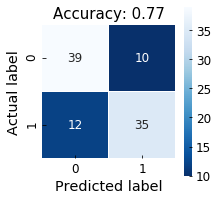

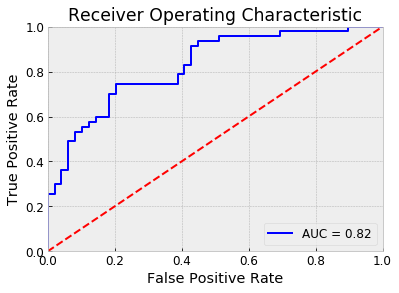

In [32]:
model_report("FakeNews Test Set Report", news_test_labels, news_pred, news_proba[:,1])

Celebrity Test Set Report
---------
             precision    recall  f1-score   support

          0       0.83      0.81      0.82        54
          1       0.79      0.80      0.80        46

avg / total       0.81      0.81      0.81       100



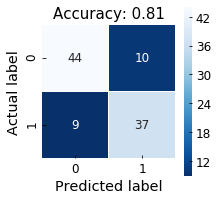

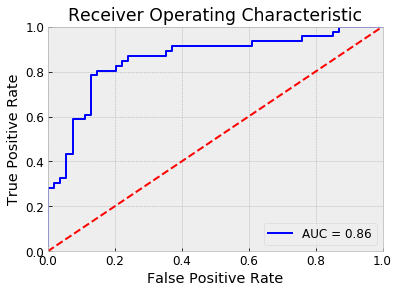

In [33]:
model_report("Celebrity Test Set Report", celeb_test_labels, celeb_pred, celeb_proba[:,1])

#### 5. Analyze Correct/Incorrect Predictions

##### i. FakeNews

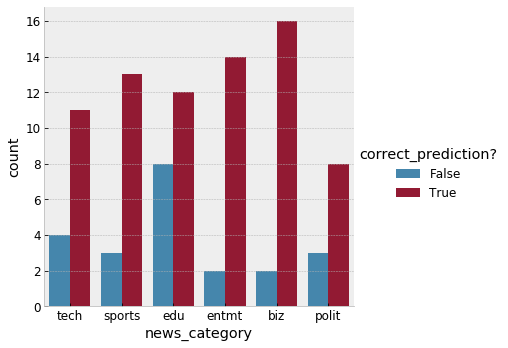

In [34]:
review_test = news_test_data
review_test['actual'] = news_test_labels
review_test['predicted'] = news_pred
review_test["correct_prediction?"] = review_test.actual == review_test.predicted
sns.catplot(x="news_category", kind = "count", hue="correct_prediction?", data = review_test)
plt.show()

In [35]:
for i in [True, False]:
    for a in [True, False]:
        example_printer(news_test_data, news_test_labels, fake = i, pos = 0, 
                    show_predict = True, pred_labels = news_pred, pred_fake = a)

_________________________________________________________________________________________________
True Label: Fake News
Predicted Label: Fake News
Correct Prediction!

Headline:
 DEMI LOVATO TAKES AIM AT HER TEEN FANS ON 'THE TONIGHT SHOW'
Article:
 Demi Lovato appeared on Jimmy Fallon's Tonight Show and did a complete roast of her teen fans. Lovato dressed in a sequinned top, pigtails, and pretended to make out with a pillow with fellow singer Ed Sheeran's face on it. During Lovato's act, Fallon responded by kissing a pillow featuring Extra's Mario Lopez.
_________________________________________________________________________________________________
_________________________________________________________________________________________________
True Label: Fake News
Predicted Label: Not Fake News
Incorrect Prediction.

Headline:
 First Amazon Prime Air delivery ends in disaster
Article:
   On Thursday, Amazon Prime Air attempted its very first package shipment in their attempt to m

##### ii. Celeb

In [36]:
for i in [True, False]:
    for a in [True, False]:
        example_printer(celeb_test_data, celeb_test_labels, fake = i, pos = 0, 
                    show_predict = True, pred_labels = celeb_pred, pred_fake = a)

_________________________________________________________________________________________________
True Label: Fake News
Predicted Label: Fake News
Correct Prediction!

Headline:
 Selena's Pals Want Justin Bieber Back To Being An Ex
Article:
  “Selena getting back together with Justin is a total disaster!” a friend told The National ENQUIRER.  Insiders are convinced that the Biebs’ booze-filled bad behavior are sure to create a deadly cocktail for 25-year-old Selena.  “She was finally on a healthy path again and getting her life in order,” said our source, following Selena’s kidney transplant.  “This is a guy who’s been a terrible influence on her for years, and the last thing she needs is to get sucked back under his spell!” 
_________________________________________________________________________________________________
_________________________________________________________________________________________________
True Label: Fake News
Predicted Label: Not Fake News
Incorrect Predi

#### 6. Analyze Feature Importance

#### i. FakeNews

In [37]:
print("Feature Name Set Lengths:", 
      len(news_ngram_punct_names) ,
      len(news_train_LIWC_vars.tolist()) ,
      len(news_train_readability_vars.tolist()),
      len(news_text_standard_names) ,
      len(news_news_category_names))
feature_names = (news_ngram_punct_names + news_train_LIWC_vars.tolist() + news_train_readability_vars.tolist() + 
                 news_text_standard_names + news_news_category_names)
print("Tracked Feature Name Shape:", len(feature_names))
print("Training Data Shape:", news_train_final.shape)
importances = news_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in news_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature Name Set Lengths: 39803 73 9 54 6
Tracked Feature Name Shape: 39945
Training Data Shape: (384, 39945)
Feature ranking:
1. , bombardier (0.220008)
2. ! like (0.193642)
3. " ' (0.047068)
4. ! here (0.038616)
5. salary (0.032547)
6. on imdb (0.030412)
7. ! ' (0.020315)
8. ' champion (0.017655)
9. it stands (0.017569)
10. ! as (0.015520)


#### ii. Celeb

In [38]:
print("Feature Name Set Lengths:", 
      len(celeb_ngram_punct_names) ,
      len(celeb_train_LIWC_vars.tolist()) ,
      len(celeb_train_readability_vars.tolist()),
      len(celeb_text_standard_names) ,
      len(celeb_dataset_names))
feature_names = (celeb_ngram_punct_names + celeb_train_LIWC_vars.tolist() + celeb_train_readability_vars.tolist() + 
                 celeb_text_standard_names + celeb_dataset_names)
print("Tracked Feature Name Shape:", len(feature_names))
print("Training Data Shape:", celeb_train_final.shape)
importances = celeb_clf.feature_importances_
std = np.std([tree.feature_importances_ for tree in celeb_clf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")
for f in range(10):
    print("%d. %s (%f)" % (f + 1, feature_names[indices[f]], importances[indices[f]]))

Feature Name Set Lengths: 98647 73 9 72 1
Tracked Feature Name Shape: 98802
Training Data Shape: (400, 98802)
Feature ranking:
1. sources say (0.049281)
2. insists tyga (0.045297)
3. ! after (0.042316)
4. the suit (0.031714)
5. ! eniko (0.031113)
6. ! charity (0.031080)
7. ! beyonce (0.024624)
8. is broken (0.022683)
9. ( july (0.021619)
10. the knicks (0.020477)
